In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

def generate_class_0(N):
    m = [0,0]
    C = [[2, 0],[0,1]]
    return np.random.multivariate_normal(m, C, N)

def generate_class_1(N):
    m_A = [-2,1]
    C_A = [[9.0/8, 7.0/8],[7.0/8, 9.0/8]]
    m_B = [3,2]
    C_B = [[2, 1],[1, 2]]
    
    pi_1 = 1.0/3
    
    x1 = np.zeros((N,2))
    for i in range(0, N):
        a = random.uniform(0, 1)
        if (a < pi_1):
            x1[i, :] = np.random.multivariate_normal(m_A, C_A, 1)
        else:
            x1[i, :] = np.random.multivariate_normal(m_B, C_B, 1)
    return x1

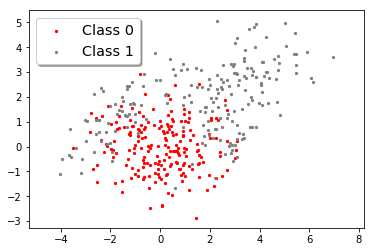

In [2]:
N = 400 # Number of samples

# Class 0, N/2 samples
x0 = generate_class_0(math.floor(N/2))
plt.scatter(x0[:, 0],x0[:, 1], label='Class 0', c='red', s=5)

# Class 1, N/2 samples
x1 = generate_class_1(math.floor(N/2))
plt.scatter(x1[:, 0],x1[:, 1], label='Class 1', c='grey', s=5)

legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.axis('equal')
plt.show()

In [3]:
x_train = np.concatenate([x0, x1])
y = np.append(np.zeros(int(N/2)), np.ones(int(N/2)))

# Shuffle the data
ind_perm = np.random.permutation(len(y))
x_train = x_train[ind_perm, :]
y = y[ind_perm]

# 1) SVM

In [4]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train, y)

# Classify class 0 as class -1
y[y == 0] = -1

# Use external implementation of the SMO algorithm
# http://jonchar.net/notebooks/SVM/
from SVM import SMOModel, gaussian_kernel, decision_function, train, plot_decision_boundary

# Set model parameters and initial values
C = 1.0
m = len(x_train)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(x_train, y, C, gaussian_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

## 1.1) Plot of the decision boundaries, and display of the support vectors

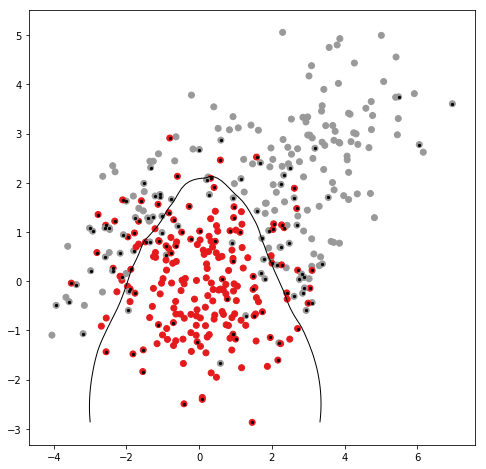

In [5]:
output = train(model)
fig, ax = plt.subplots(figsize=(8,8))
grid, ax = plot_decision_boundary(output, ax)

The plot above shows the two classes (class 0 in red, and class 1 in grey), with the decision boundary. Points that also have a black dot are support vectors.

In [6]:
# Support vectors have non-zero alphas
mask = model.alphas != 0.0
frac_support_vectors = len(model.X[:,0][mask]) / len(model.X[:,0])

print("Fraction of training data points that are support vectors:")
print(frac_support_vectors)

Fraction of training data points that are support vectors:
0.3575


## 1.2) Comparison of misclassification performance between SVM and kernelized logistic regression

In [7]:
classified_points = [decision_function(model.alphas, model.y,
                               model.kernel, model.X,
                               np.array(x), model.b) for x in model.X]
classified_points = np.array(classified_points).reshape(len(model.X[:, 0]), 1)
        
classified_points[classified_points < 0] = -1
classified_points[classified_points > 0] = 1

misclassification_error = 0
for i in range(len(y)):
    if classified_points[i] != y[i]:
        misclassification_error += 1        

print("Probability of incorrect classification:")
print(misclassification_error / len(y))

Probability of incorrect classification:
0.14


For kernelized regression we got a misclassification error probability of about ~0.15, which is very similar to

# 2) Adaboost

## 2.1) Plot of the decision boundaries